Working through the [FEniCSx Tutorial by JS Dokken](https://jsdokken.com/dolfinx-tutorial/index.html).

## [Chapter 1: Fundamentals](https://jsdokken.com/dolfinx-tutorial/chapter1/fundamentals.html)
We will solve the Poisson equation 
$$
-\nabla^2 u = -6
$$
in a unit square domain 
$$
\Omega = (0,1) \times (0,1)
$$
with a Dirichlet boundary condition
$$
u_D(x,y) = 1 + x^2 + 2y^2 \text{ on } \partial\Omega
$$
using FEniCSx.

### Generating a simple mesh
First, we define the mesh. Note that this relies on the `mpi4py` library, which is used for parallel computing in Python.



In [1]:
from mpi4py import MPI
from dolfinx import mesh
domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral)


### Defining the function space
Recall that the finite element method turns a function space into a discrete space of functions. Mathematically, we usually represent this in a fashion like this:
$$
u(\vec{x}) \approx \sum_{i=1}^{N} u_i \phi_i(\vec{x})
$$
where $\phi_i$ are the basis functions of the finite element space and $u_i$ are the coefficients of the function in that space. Remember, computers are really good at linear algebra, so we can think of this as a matrix-vector product where the matrix is defined by the basis functions and the vector is the coefficients of the function we want to represent.

Next, we define the function space and create a function for the dirichelet boundary condition. The `Lagrange` element of degree 1 is used for the function space, which assumes linear basis functions. The `interpolate` method converts the function for the boundary condition into a discrete form that can be used in the finite element method.


In [2]:
from dolfinx.fem import functionspace
V = functionspace(domain, ("Lagrange", 1))

from dolfinx import fem
uD = fem.Function(V)
uD.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)

Since we have the boundary condition defined in terms of the discrete function space. Now we can apply the boundary values to ***all degrees of freedom on*** the boundary of the mesh. This is done by setting the values of the function to the boundary condition values at the degrees of freedom that are on the boundary of the mesh.

In [3]:
import numpy as np

# Create facet to cell connectivity required to determine the boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

At some point, I feel that the linear algebra formulation is an incomplete model of the finite element method. I currently don't know what the authors mean by degrees of freedom, and I do not understand why the ***bold-italic phrase*** above is required. There is a snippet on the tutorial page that is as follows:

> Many people expect there to be a 1-1 correspondence between the mesh coordinates and the coordinates of the degrees of freedom. However, this is only true in the case of `Lagrange, 1` elements on a first order mesh. Therefore, in DOLFINx we use separate local numbering for the mesh coordinates and the dof coordinates. To obtain the local dof coordinates we can use `V.tabulate_dof_coordinates()`, while the ordering of the local vertices can be obtained by `mesh.geometry.x`.

With the above in mind, we can create the Dirichelet boundary condition function and apply the boundary values to the degrees of freedom on the boundary of the mesh.

In [4]:
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

### Defining the variational formulation
#### Trial and test functions

Now we will build the variational formulation of the problem. In order to do this, we will use the Unified Form Language (UFL) to define the trial function $u(x)$ and the test function $v(x)$. The trial function represents the solution we are trying to find, while the test function is used to define the weak form of the equation.

In [5]:
import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

#### Source term
Now, define the source term. As $f(x,y) = -6$, we can define it as a constant function in the function space $V$. This complicated definition is used, rather than a simpler definition like `f = -6`, because this defines the source term in such a way that is faster for computational purposes.

In [6]:
from dolfinx import default_scalar_type
f = fem.Constant(domain, default_scalar_type(-6))

#### Linear and bilinear forms
Now define the variational problem. The weak form of the Poisson equation is given by:
$$
a(u, v) = L(v)
$$ 
where $a(u, v)$ is the bilinear form and $L(v)$ is the linear form. In this case, we define the bilinear form as:
$$
a(u, v) = \int_{\Omega} \nabla u \cdot \nabla v \, dx
$$
and the linear form as:
$$
L(v) = \int_{\Omega} f v \, dx
$$
Note that the command `ufl.dot` is not appropriate for computing an inner product when complex numbers are involved. Many other methods/definitions are possible.

In [7]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

### Doing the Linear Algebra
Now we can do some linear algebra. The `petsc` module is not required for this, but `dolfinx` has a wrapper for this function. Note, that `petsc` is a library for solving linear and nonlinear equations that relies on the `mpi4py` library for parallel computing. 

Using `problem.solve()` we solve the linear system of equations and return a `dolfinx.fem.Function` containing the solution.

In [8]:
from dolfinx.fem.petsc import LinearProblem
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

### Computing the error
Computing the error is done by comparing the computed solution to the exact solution. 

In [9]:
V2 = fem.functionspace(domain, ("Lagrange", 2))
uex = fem.Function(V2)
uex.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)

Method 1 for computing the error:

$$
E = \sqrt{\int_{\Omega} (u_{\text{exact}} - u_{\text{computed}})^2 \, dx}   
$$


In [10]:
L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))

Secondly, we compute the maximum error at any degree of freedom. As the finite element function
can be expressed as a linear combination of basis functions $\phi_j$, spanning the space $V:u=\sum_{j=1}^{N} u_j \phi_j$. By writing `problem.solve()` we compute all the coefficients $\left\{u_i\right\}$. These values are known as the degrees of freedom (dofs). We can access the degrees of freedom by accessing the underlying vector in `uh`. However, as a second order function space has more dofs than a linear function space, we cannot compare these arrays directly. As we allready have interpolated the exact solution into the first order space when creating the boundary condition, we can compare the maximum values at any degree of freedom of the approximation space.

In [11]:
error_max = np.max(np.abs(uD.x.array-uh.x.array))
# Only print the error on one process
if domain.comm.rank == 0:
    print(f"Error_L2 : {error_L2:.2e}")
    print(f"Error_max : {error_max:.2e}")

Error_L2 : 8.24e-03
Error_max : 3.55e-15


### Plotting the mesh using pyvista
We will visualizing the mesh using pyvista, an interface to the VTK toolkit. We start by converting the mesh to a format that can be used with `pyvista`. To do this we use the function `dolfinx.plot.vtk_mesh`. The first step is to create an unstructured grid that can be used by `pyvista`. We need to start a virtual framebuffer for plotting through docker containers. You can print the current backend and change it with `pyvista.set_jupyter_backend(backend)`

In [14]:
import pyvista
print(pyvista.global_theme.jupyter_backend)

trame


In [15]:
from dolfinx import plot
pyvista.start_xvfb()
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)


Start plotting with the `pyvista.Plotter` to visualize the mesh.


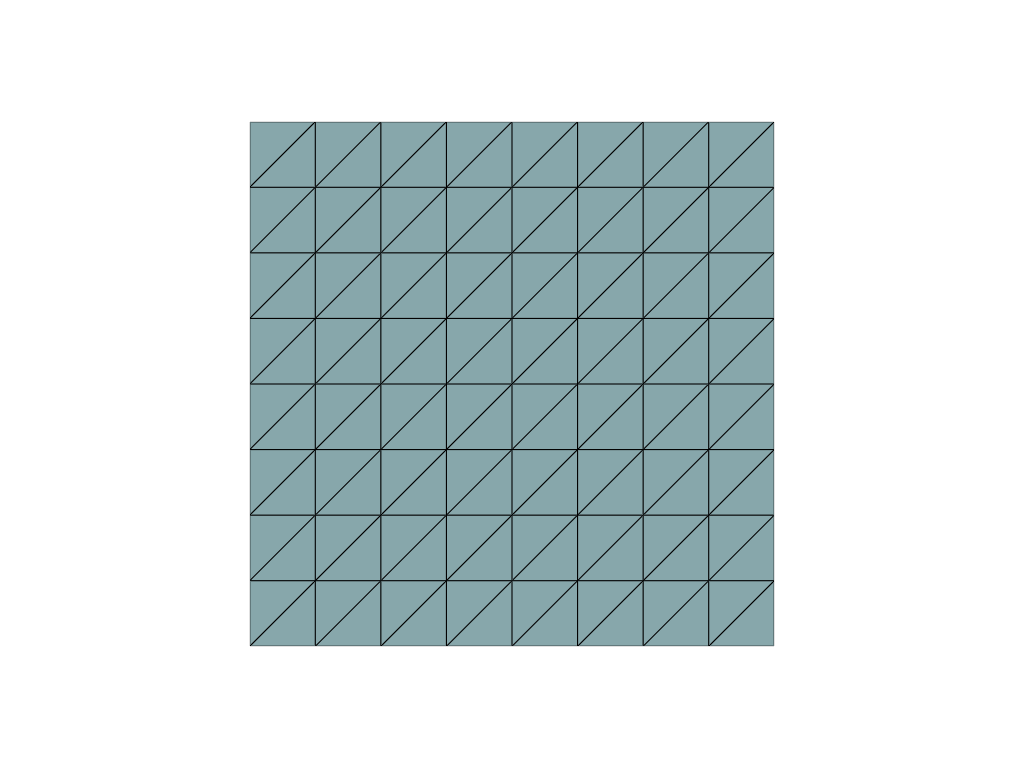

In [16]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")


### Plotting a function using pyvista
We want to plot the solution `uh`. As the function space used to defined the mesh is disconnected from the function space defining the mesh, we create a mesh based on the dof coordinates for the function space `V`. We use `dolfinx.plot.vtk_mesh` with the function space as input to create a mesh with mesh geometry based on the dof coordinates.

In [17]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)

Next, we create the `pyvista.UnstructuredGrid` and add the dof-values to the mesh.

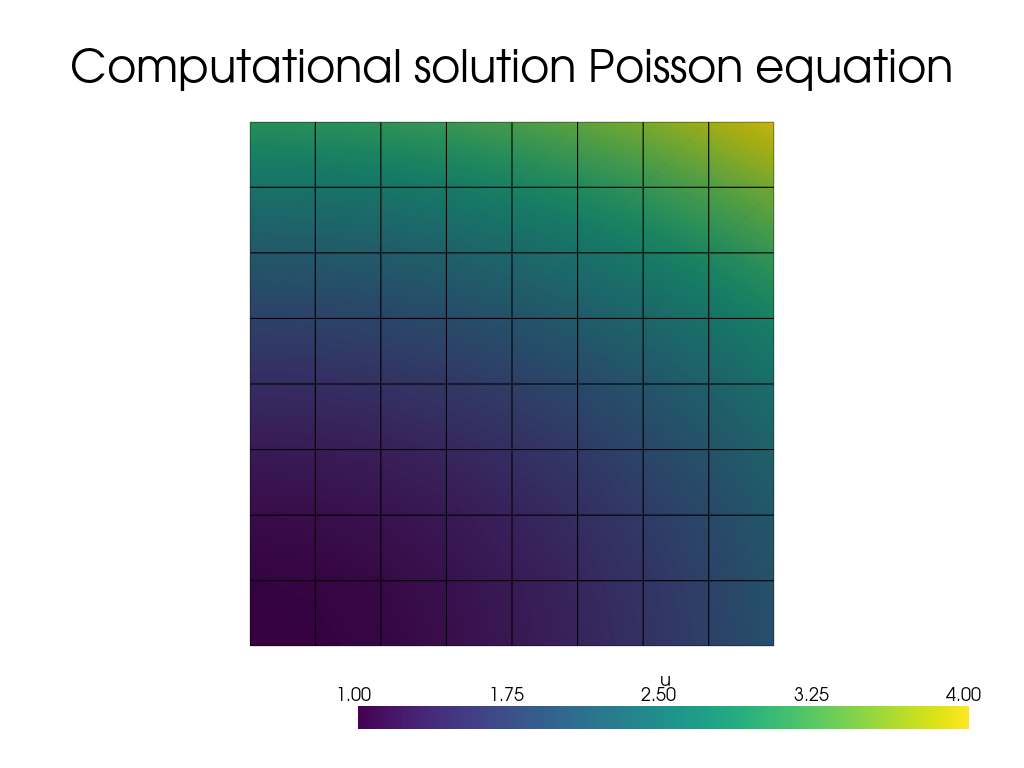

In [22]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.add_title("Computational solution Poisson equation")
if not pyvista.OFF_SCREEN:
    u_plotter.show()

We can turn this into a 3D plot by using `warp_by_scalar` to warp the mesh by the values of the function `uh`. This will create a 3D plot of the solution, where the height of the mesh corresponds to the value of the function at that point.

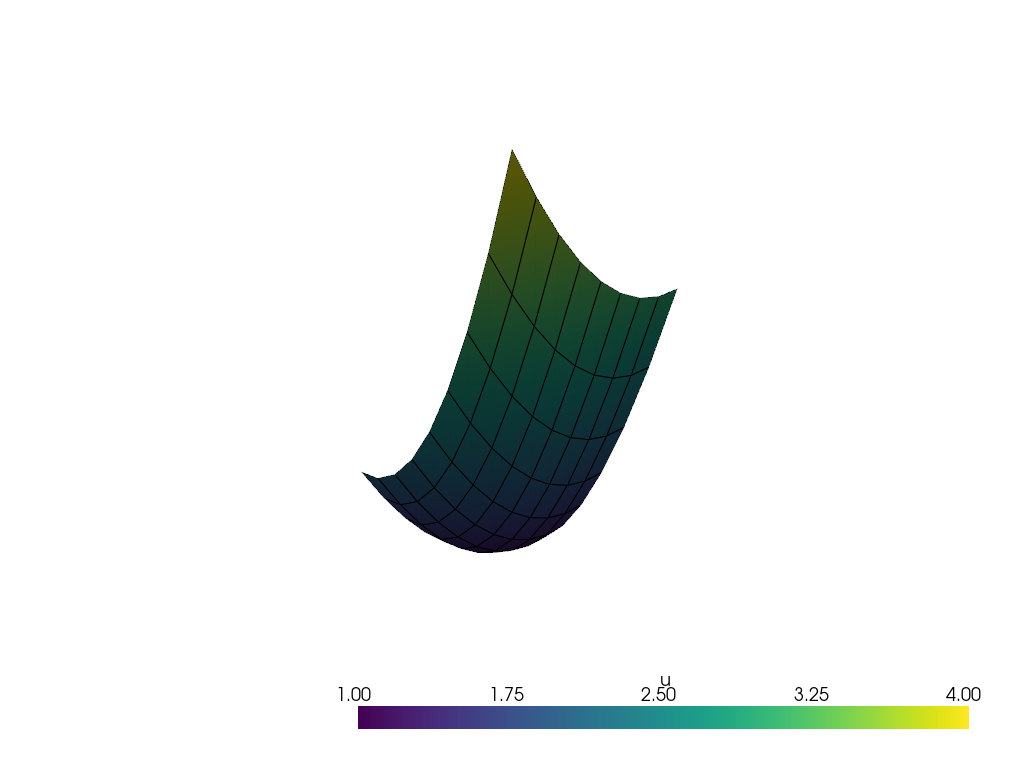

In [19]:
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()


Let's see if I can repeat this for the exact solution.


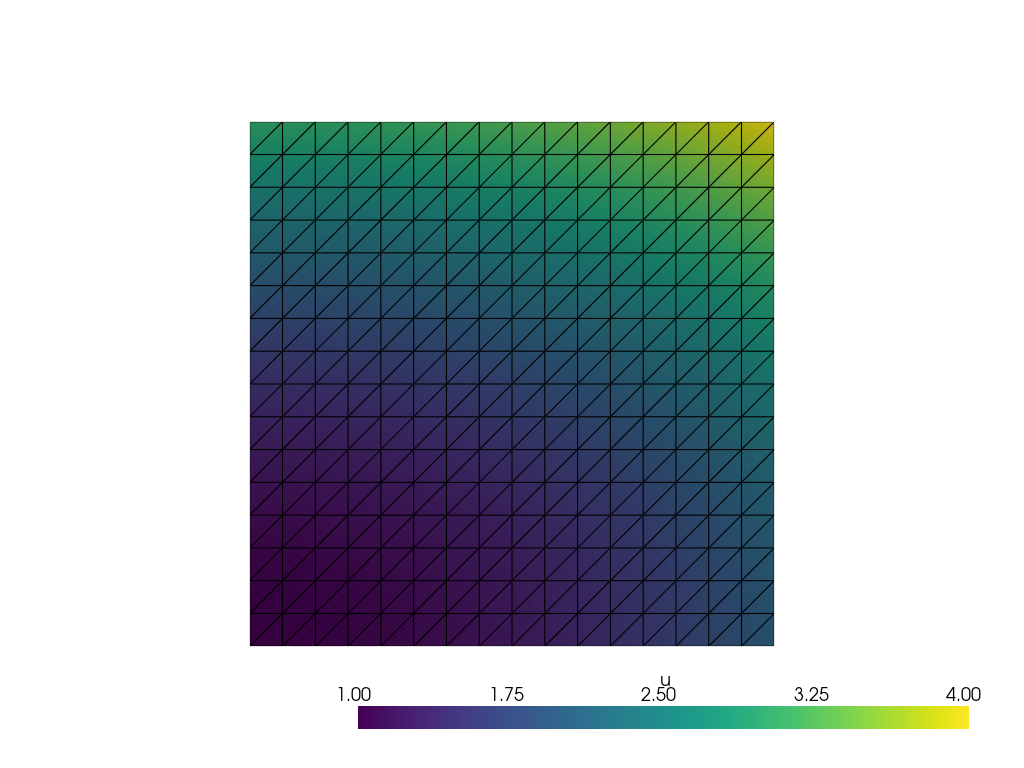

In [21]:
uex_topology, uex_cell_types, uex_geometry = plot.vtk_mesh(V2)

uex_grid = pyvista.UnstructuredGrid(uex_topology, uex_cell_types, uex_geometry)
uex_grid.point_data["u"] = uex.x.array.real
uex_grid.set_active_scalars("u")
uex_plotter = pyvista.Plotter()
uex_plotter.add_mesh(uex_grid, show_edges=True)
uex_plotter.view_xy()

if not pyvista.OFF_SCREEN:
    uex_plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")